In [ ]:
from google.colab import drive
drive.mount('/content/drive')
ME_592_root = '/content/drive/Shareddrives/ME_592'

Mounted at /content/drive


#Problem 1
Download the dataset and overlay the positive and negative grasping rectangles for each image on the raw image using the coordinates of the rectangles provided.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
from skimage.transform import rotate, resize
from google.colab.patches import cv2_imshow
import os
from matplotlib import image
from matplotlib import pyplot as plt
import skimage
from skimage import data, draw, io
from google.colab.patches import cv2_imshow

In [ ]:
directory = '/content/drive/Shareddrives/ME_592/archive/' 
from google.colab.patches import cv2_imshow
from sklearn import preprocessing

for filename in os.listdir(directory):
    if len(filename)<4:
      for i in range(0,100):
        f = open(directory+filename+'/'+'pcd'+filename+str(i).zfill(2)+'cneg.txt','r')
        Lines = f.readlines()
        xneg = []
        yneg = []
        for line in Lines:
          txt = line.split()
          first = float(txt[1])
          second = float(txt[0])  
          xneg.append(first)
          yneg.append(second)

        f1 = open(directory+filename+'/'+'pcd'+filename+str(i).zfill(2)+'cpos.txt','r')
        Lines = f1.readlines()
        xpos = []
        ypos = []
        for line in Lines:
          txt = line.split()
          first = float(txt[1])
          second = float(txt[0])  
          xpos.append(first)
          ypos.append(second)
        
        img = cv2.imread(directory+filename+'/'+'pcd'+filename+str(i).zfill(2)+'r.png',1)
        countXneg = 0
        countXpos = 0
        x = []
        y = []
        x1 = []
        y1 = []
        xRange = len(xneg) + 1
        x1Range = len(xpos) + 1
        for k in range(xRange):
            if(countXneg == 4):
              row1, col1 = draw.polygon_perimeter(x,y)
              img[row1, col1, :] = [150, 24, 0]
              fig, ax = plt.subplots(1,1)
              ax.axis('off')
              ax.imshow(img)
              x = []
              y = []
              if(len(xneg) != 0):
                x.append(xneg.pop())
                y.append(yneg.pop())
                countXneg = 1
            else:
              x.append(xneg.pop())
              y.append(yneg.pop())
              countXneg += 1
        
        for j in range(x1Range):
            if(countXpos == 4):
              row1, col1 = draw.polygon_perimeter(x1,y1)
              img[row1, col1, :] = [0, 78, 106]
              fig, ax = plt.subplots(1,1)
              ax.axis('off')
              ax.imshow(img)
              x1 = []
              y1 = []
              if(len(xpos) != 0):
                x1.append(xpos.pop())
                y1.append(ypos.pop())
                countXpos = 1
            else:
              x1.append(xpos.pop())
              y1.append(ypos.pop())
              countXpos += 1
            cv2.imwrite(directory+filename+'/'+'pcd'+filename+str(i).zfill(2)+'overlay.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Problem 2 
Using the PNG images and point cloud data, register the point cloud data to the
PNG images to obtain a 4 channel RGB-D image. Please take a look at the fol-
lowing source code as reference on how to create depth images from point cloud data.
https://github.com/skumra/robotic-grasping/blob/master/utils/dataset_
processing/image.py

In [ ]:
import warnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
from skimage.transform import rotate, resize

In [38]:
warnings.filterwarnings("ignore", category=UserWarning)


class Image:
    """
    Wrapper around an image with some convenient functions.
    """

    def __init__(self, img):
        self.img = img

    def __getattr__(self, attr):
        # Pass along any other methods to the underlying ndarray
        return getattr(self.img, attr)

    @classmethod
    def from_file(cls, fname):
        return cls(imread(fname))

    def copy(self):
        """
        :return: Copy of self.
        """
        return self.__class__(self.img.copy())

    def crop(self, top_left, bottom_right, resize=None):
        """
        Crop the image to a bounding box given by top left and bottom right pixels.
        :param top_left: tuple, top left pixel.
        :param bottom_right: tuple, bottom right pixel
        :param resize: If specified, resize the cropped image to this size
        """
        self.img = self.img[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
        if resize is not None:
            self.resize(resize)

    def cropped(self, *args, **kwargs):
        """
        :return: Cropped copy of the image.
        """
        i = self.copy()
        i.crop(*args, **kwargs)
        return i

    def normalise(self):
        """
        Normalise the image by converting to float [0,1] and zero-centering
        """
        self.img = self.img.astype(np.float32) / 255.0
        self.img -= self.img.mean()

    def resize(self, shape):
        """
        Resize image to shape.
        :param shape: New shape.
        """
        if self.img.shape == shape:
            return
        self.img = resize(self.img, shape, preserve_range=True).astype(self.img.dtype)

    def resized(self, *args, **kwargs):
        """
        :return: Resized copy of the image.
        """
        i = self.copy()
        i.resize(*args, **kwargs)
        return i

    def rotate(self, angle, center=None):
        """
        Rotate the image.
        :param angle: Angle (in radians) to rotate by.
        :param center: Center pixel to rotate if specified, otherwise image center is used.
        """
        if center is not None:
            center = (center[1], center[0])
        self.img = rotate(self.img, angle / np.pi * 180, center=center, mode='symmetric', preserve_range=True).astype(
            self.img.dtype)

    def rotated(self, *args, **kwargs):
        """
        :return: Rotated copy of image.
        """
        i = self.copy()
        i.rotate(*args, **kwargs)
        return i

    def show(self, ax=None, **kwargs):
        """
        Plot the image
        :param ax: Existing matplotlib axis (optional)
        :param kwargs: kwargs to imshow
        """
        if ax:
            ax.imshow(self.img, **kwargs)
        else:
            plt.imshow(self.img, **kwargs)
            plt.show()

    def zoom(self, factor):
        """
        "Zoom" the image by cropping and resizing.
        :param factor: Factor to zoom by. e.g. 0.5 will keep the center 50% of the image.
        """
        sr = int(self.img.shape[0] * (1 - factor)) // 2
        sc = int(self.img.shape[1] * (1 - factor)) // 2
        orig_shape = self.img.shape
        self.img = self.img[sr:self.img.shape[0] - sr, sc: self.img.shape[1] - sc].copy()
        self.img = resize(self.img, orig_shape, mode='symmetric', preserve_range=True).astype(self.img.dtype)

    def zoomed(self, *args, **kwargs):
        """
        :return: Zoomed copy of the image.
        """
        i = self.copy()
        i.zoom(*args, **kwargs)
        return i


class DepthImage(Image):
    def __init__(self, img):
        super().__init__(img)

    @classmethod
    def from_pcd(cls, pcd_filename, shape, default_filler=0, index=None):
        """
            Create a depth image from an unstructured PCD file.
            If index isn't specified, use euclidean distance, otherwise choose x/y/z=0/1/2
        """
        img = np.zeros(shape)
        if default_filler != 0:
            img += default_filler

        with open(pcd_filename) as f:
            for l in f.readlines():
                ls = l.split()

                if len(ls) != 5:
                    # Not a point line in the file.
                    continue
                try:
                    # Not a number, carry on.
                    float(ls[0])
                except ValueError:
                    continue

                i = int(ls[4])
                r = i // shape[1]
                c = i % shape[1]

                if index is None:
                    x = float(ls[0])
                    y = float(ls[1])
                    z = float(ls[2])

                    img[r, c] = np.sqrt(x ** 2 + y ** 2 + z ** 2)

                else:
                    img[r, c] = float(ls[index])

        return cls(img / 1000.0)

    @classmethod
    def from_tiff(cls, fname):
        return cls(imread(fname))

    def inpaint(self, missing_value=0):
        """
        Inpaint missing values in depth image.
        :param missing_value: Value to fill in teh depth image.
        """
        # cv2 inpainting doesn't handle the border properly
        # https://stackoverflow.com/questions/25974033/inpainting-depth-map-still-a-black-image-border
        self.img = cv2.copyMakeBorder(self.img, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
        mask = (self.img == missing_value).astype(np.uint8)

        # Scale to keep as float, but has to be in bounds -1:1 to keep opencv happy.
        scale = np.abs(self.img).max()
        self.img = self.img.astype(np.float32) / scale  # Has to be float32, 64 not supported.
        self.img = cv2.inpaint(self.img, mask, 1, cv2.INPAINT_NS)

        # Back to original size and value range.
        self.img = self.img[1:-1, 1:-1]
        self.img = self.img * scale
        #cv2_imshow(self.img)
    def gradients(self):
        """
        Compute gradients of the depth image using Sobel filtesr.
        :return: Gradients in X direction, Gradients in Y diretion, Magnitude of XY gradients.
        """
        grad_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, borderType=cv2.BORDER_DEFAULT)
        grad_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, borderType=cv2.BORDER_DEFAULT)
        grad = np.sqrt(grad_x ** 2 + grad_y ** 2)

        return DepthImage(grad_x), DepthImage(grad_y), DepthImage(grad)

    def normalise(self):
        """
        Normalise by subtracting the mean and clippint [-1, 1]
        """
        self.img = np.clip((self.img - self.img.mean()), -1, 1)


class WidthImage(Image):
    """
    A width image is one that describes the desired gripper width at each pixel.
    """

    def zoom(self, factor):
        """
        "Zoom" the image by cropping and resizing.  Also scales the width accordingly.
        :param factor: Factor to zoom by. e.g. 0.5 will keep the center 50% of the image.
        """
        super().zoom(factor)
        self.img = self.img / factor

    def normalise(self):
        """
        Normalise by mapping [0, 150] -> [0, 1]
        """
        self.img = np.clip(self.img, 0, 150.0) / 150.0


img=cv2.imread('/content/drive/MyDrive/ME_592/archive/01/pcd0100r.png')
f_object=Image(img)
f_object2=DepthImage(f_object)
f2=f_object2.from_pcd('/content/drive/MyDrive/ME_592/archive/01/pcd0100.txt',[480,640])
cv2_imshow(np.array(f2)*128)


In [46]:
import os
#640*480
# assign directory

#NOTE - this has to be our group's shared drive, not a personal Google Drive '/content/drive/MyDrive/ME_592/archive/'
directory = '/content/drive/Shareddrives/ME_592/archive/' 
from google.colab.patches import cv2_imshow
from sklearn import preprocessing
# iterate over files in
# that directory
for filename in os.listdir(directory):
    if filename=='10':
      index=35
    elif filename=='09':
      index=50
    else:
      index=100

    if len(filename)<4:
      for i in range(0,index):
        img=cv2.imread(directory+filename+'/'+'pcd'+filename+str(i).zfill(2)+'r.png')
        f_object=Image(img)        
        f_object2=DepthImage(f_object)
        f2=f_object2.from_pcd(directory+filename+'/'+'pcd'+filename+str(i).zfill(2)+'.pcd',[480,640])
        #print(np.array(f2))
        f2.inpaint()
        cv2.imwrite(directory+filename+'/'+'pcd'+filename+str(i).zfill(2)+'depth.png',np.array(f2)*128)
    

In [44]:
['08', '05', '04', '06', '07', '01', '03', '02', '09', 'backgrounds']

['08', '05', '04', '06', '07', '01', '10', '03', '02', '09', 'backgrounds']

In [ ]:
im_depth=cv2.imread('/content/drive/MyDrive/ME_592/archive/01/pcd0100depth.png',0)


In [ ]:
im_rgb=cv2.imread('/content/drive/MyDrive/ME_592/archive/01/pcd0100r.png',1)

In [ ]:
rgbd=np.zeros((480,640,4))
rgbd[:,:,0:3]=im_rgb
rgbd[:,:,3]=im_depth

# Problem 3

Using the RGB-D images above, extract sub-patches of images that are found within
the coordinates of the positive grasping rectangles. Now, we will extract 4 channels
worth of features from these sub-patches. Convert the first 3 channels of the RGB-
D image to YUV color format to get features representing the color and intensity.
Next, extract the last channel of the RGB-D image and convert it to a single image
representing the depth of the features.

In [ ]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

###--Handle the coordinates for cropping
def coordinates(path):
  pos_coordinates = open(path, 'r')
  list = []
  for count, value in enumerate(pos_coordinates):
    list += value.strip().split(' ')

  list_ints = []
  for element in list:
    list_ints.append(int(float(element)))

  np_ints = np.array(list_ints)
  np_ints_reshape = np_ints.reshape(int(len(np_ints)/2), 2)
  #print(np_ints_reshape)

  return np_ints_reshape

###--Remove bezels by perspective transform
def remove_bezels(img):
  #Convert to gray, and threshold
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

  #Find the max-area contour
  cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
  cnt = sorted(cnts, key=cv2.contourArea)[-1]
  #print(len(cnts))

  # Extract the rotated rect from the contour
  rot_rect = cv2.minAreaRect(cnt)

  # Extract width and height
  width, height = (rot_rect[1][0], rot_rect[1][1]) # rect size

  # Set model points : The original shape
  model_pts = np.array([[0,height],[0,0],[width,0],[width,height]]).astype('float32')

  # Set detected points : Points on the image
  current_pts = cv2.boxPoints(rot_rect).astype('float32')

  matrix = cv2.getPerspectiveTransform(current_pts ,model_pts)

  # Carry out perspective transformation
  img_transformed = cv2.warpPerspective(img, matrix, (int(width),int(height)), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

  return img_transformed

###--Crop image using mask
def crop(img, coordinates):
  mask = np.zeros(img.shape[0:2], dtype=np.uint8)
  points = coordinates
  
  cv2.drawContours(mask, [points], -1, (255, 255, 255), -1, cv2.LINE_AA)
  res = cv2.bitwise_and(img,img,mask = mask)
  rect = cv2.boundingRect(points) # returns (x,y,w,h) of the rect
  img_cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]
  img_output = remove_bezels(img_cropped)
  
  #cv2_imshow(img_cropped)
  #cv2_imshow(img_output)

  return img_output


#NOTE - this has to be our group's shared drive, not a personal Google Drive '/content/drive/MyDrive/ME_592/archive/'
directory = '/content/drive/Shareddrives/ME_592/archive/' 
#print(os.listdir(directory))

for filename in os.listdir(directory):
    if len(filename)<4:
      for i in range(0,100):
        print(directory+filename+'/'+'pcd'+filename+str(i).zfill(2)+'r.png')
        img=cv2.imread(directory+filename+'/'+'pcd'+filename+str(i).zfill(2)+'r.png')
        img_depth = cv2.imread(directory+filename+'/'+'pcd'+filename+str(i).zfill(2)+'depth.png')
        #cv2_imshow(img)
        
        img_converted = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        #cv2_imshow(img_converted)

        crop_coordinates = coordinates(directory+filename+'/'+'pcd'+filename+str(i).zfill(2)+'cpos.txt')

        for j in range(0, len(crop_coordinates), 4):
          poly = crop_coordinates[j:j+4]
          #cv2.polylines(img, [poly], True, (0,255,0), thickness=1)
          img_crop = crop(img_converted, poly)
          img_crop_depth = crop(img_depth, poly)
          #cv2.imwrite(directory+filename+'/'+'pcd'+filename+str(i).zfill(2)+'rec'+str(j)+'.png', np.array(img_crop))
          #cv2.imwrite(directory+filename+'/'+'pcd'+filename+str(i).zfill(2)+'rec_depth'+str(j)+'.png', np.array(img_crop_depth))
    

/content/drive/Shareddrives/ME_592/archive/08/pcd0800r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0801r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0802r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0803r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0804r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0805r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0806r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0807r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0808r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0809r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0810r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0811r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0812r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0813r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0814r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0815r.png
/content/drive/Shareddrives/ME_592/archive/08/pcd0816r.p

IndexError: ignored

#Problem 4
Next, apply PCA Whitening to the depth features extracted above to further reduce
any bias in the depth features.

In [ ]:
import os
from numpy import linalg as LA
import timeit
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Set directory to shared 592 drive
directory = os.path.join(ME_592_root, 'archive')

# Set dimensions to rescale images (a more manageable 35x35)
# Set dimensions to view images (a clearly visible 250x250) 
dims = (35, 35)
disp_dims = (250, 250)

# Epsilon (fudge factor)
epsilon = 40

# Store images in index dictionary for later access
count = 0
index_dict = {}

def get_image(x, i, show = True, disp_dims = (250, 250)):
  image = x.T[i]
  image = image.reshape(dims)
  if show: cv2_imshow(cv2.resize(image, disp_dims))
  return image

for subfolder in os.listdir(directory):
  search_dir = os.path.join(directory, subfolder)
  for file in os.listdir(search_dir):
    if 'rec_depth' in file and 'whitened' not in file:
      # Read in image, resize to fit all in 1225 dimensions (one per pizel)
      image = cv2.imread(os.path.join(search_dir, file), 0)
      image = cv2.resize(image, dims)

      # cv2_imshow(cv2.resize(image, disp_dims))

      # Get shapes for resized images
      x_n = image.shape[0]
      y_n = image.shape[1]

      # Reshape images to (1, 1225)
      # Center around zero by subtrating mean
      zero_center = image.reshape(1, x_n * y_n)
      mean = image.mean()
      zero_center = zero_center - mean

      # Build x array iteravely
      if count == 0:
        x=zero_center
      else:
        x=np.concatenate((x, zero_center), axis = 0)

      # Update dictionary for later lookup of files
      index_dict.update({file: count})
      
      count +=1

# Calculate covariance
cov = np.cov(x, rowvar=False)

# Find singular value decomposition
u, s, vh = np.linalg.svd(cov)

# Equation for PCA on Stanford website
c0 = 1/np.sqrt(s+epsilon)
c1 = c0.dot(u.T)
x_pca = np.matmul(np.diag(c1), x.T)

# Rescale results to between 0/255
x_pca_rescaled = (x_pca - x_pca.min()) / (x_pca.max() - x_pca.min()) * 255

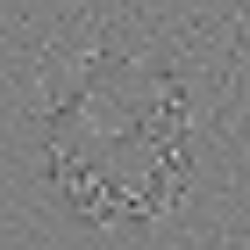

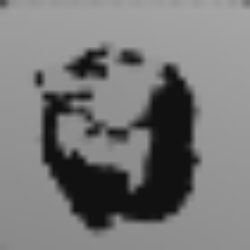

In [ ]:
# The first image had a mean of ~120, so show the whitened vs original image
image = get_image(x_pca_rescaled, 0)
image = get_image(x.T + 120, 0)

for subfolder in os.listdir(directory):
  search_dir = os.path.join(directory, subfolder)
  for file in os.listdir(search_dir):
    if file in index_dict:
      index = index_dict[file]

      whitened_image = get_image(x_pca_rescaled, index, show = False)
      new_name = file.replace('.png', '_whitened.png')
      
      # print(os.path.join(search_dir, f'{new_name}'))
      # cv2.imwrite(os.path.join(search_dir, f'{new_name}'), whitened_image)

#Problem 5 
Visualize the point cloud data using Rviz (by converting the .txt files to .ply files,
and then using the ply files create rosbag files to render in Rviz). 

In [ ]:
pip install open3d

     |████████████████████████████████| 408.6 MB 27 kB/s 
     |████████████████████████████████| 8.7 MB 21.6 MB/s 
     |████████████████████████████████| 4.3 MB 41.2 MB/s 
     |████████████████████████████████| 596 kB 43.1 MB/s 
     |████████████████████████████████| 1.1 MB 40.0 MB/s 
     |████████████████████████████████| 428 kB 38.1 MB/s 
     |████████████████████████████████| 61 kB 6.7 MB/s 
     |████████████████████████████████| 397 kB 47.0 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 130 kB 42.4 MB/s 
     |████████████████████████████████| 79 kB 4.6 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1
  Attempting uninstall: jupyter-client
    Found exi

In [ ]:
import open3d as o3d
import os

directory = os.path.join(ME_592_root, 'archive1')

'''
Code used to rename .txt files to .pcd. Only needs to run once, do not uncomment

for subfolder in os.listdir(directory):
  for filename in os.listdir(os.path.join(directory, subfolder)):
    # Find point clouds
    os.chdir(os.path.join(directory, subfolder))
    if len(filename) < 12:
      os.rename(filename, os.path.splitext(filename)[0] + '.pcd') 
      print(os.path.splitext(filename)[0] + '.pcd')
'''

# Read point clouds and convert to .ply
for subfolder in os.listdir(directory):
  os.chdir(os.path.join(directory, subfolder))
  for filename in os.listdir(os.path.join(directory, subfolder)):
    # Find point clouds
    if '.pcd' in filename:
      new_filename = filename[:-3] + 'ply'
      pcd = o3d.io.read_point_cloud(filename)
      o3d.io.write_point_cloud(new_filename, pcd)
      print(os.path.join(directory, subfolder))
      print(filename)
      # print(done)



/content/drive/Shareddrives/ME_592/archive1/08
pcd0800.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0801.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0802.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0803.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0804.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0805.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0806.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0807.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0808.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0809.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0810.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0811.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0812.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0813.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0814.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0815.pcd
/content/drive/Shareddrives/ME_592/archive1/08
pcd0816.p